# Multiple Classification with the Beans Dataset

The TFDS beans dataset is great to practice convolutional nerual networks on. In this project we will use two models:


* A simple CNN
* A deeper CNN





# Imports and Functions

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(f'Tensorflow version {tf.__version__}')
print(f'Datasets version {tfds.__version__}')

Tensorflow version 2.12.0
Datasets version 4.9.2


In [2]:
# Graphing Function
def graph_data(x, y, title=None, x_label=None, y_label=None):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.show()

# Load the Data

In [ ]:
# Load the dataset
(ds_train, ds_validation), ds_info = tfds.load(
    name='beans',
    split=['train', 'validation'],
    as_supervised=True,
    with_info=True
)

# Visualize the Data

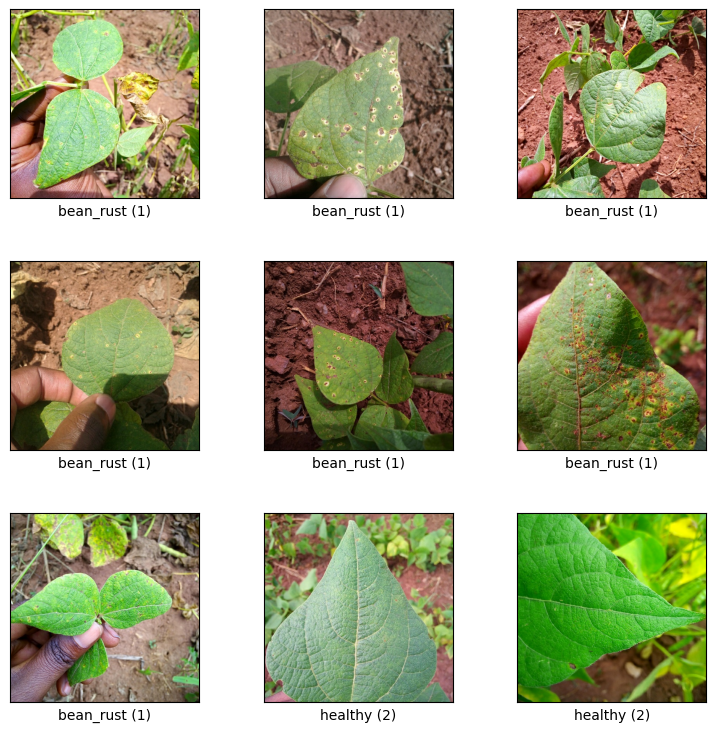

In [4]:
# View some bean leaf images
fig = tfds.show_examples(ds_validation, ds_info)

In [5]:
# View the data set information
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='/root/tensorflow_datasets/beans/0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <Spli

# Preprocess the Data
Resize, normalize, and augment the images.

In [6]:
# Some global variables
IMAGE_SIZE = 300
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
# Create a function to resize, normalize, and augment images
rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(
        lambda i, y: (rescale(i), y),
        num_parallel_calls=AUTOTUNE
        )

    # Shuffle the dataset
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch the dataset
    ds = ds.batch(BATCH_SIZE)

    # Augment the data if training set
    if augment:
        ds = ds.map(
            lambda i, y: (data_augmentation(i, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Return buffered dataset
    return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Pre-process and tune the datasets for training, remove cache to clear memory
ds_train_process = prepare(ds_train, shuffle=True, augment=True)
ds_validation_process = prepare(ds_validation)

# Make a Test Model
Make sure the datasets work in a model.

In [9]:
# Make a very easy model just to test things
model_easy = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_easy.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_easy.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1440000)           0         
                                                                 
 dense (Dense)               (None, 32)                46080032  
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 46,080,579
Trainable params: 46,080,579
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Target is val_accuracy > 0.75
history = model_easy.fit(
    ds_train_process,
    epochs=10,
    validation_data=ds_validation_process
)

Epoch 1/10
33/33 [==============================] - 16s 68ms/step - loss: 27.0224 - accuracy: 0.3520 - val_loss: 2.4708 - val_accuracy: 0.3083
Epoch 2/10
33/33 [==============================] - 3s 56ms/step - loss: 1.3746 - accuracy: 0.3888 - val_loss: 1.4301 - val_accuracy: 0.4211
Epoch 3/10
33/33 [==============================] - 3s 59ms/step - loss: 1.8339 - accuracy: 0.4023 - val_loss: 1.5297 - val_accuracy: 0.4436
Epoch 4/10
33/33 [==============================] - 3s 56ms/step - loss: 1.4331 - accuracy: 0.4110 - val_loss: 1.7951 - val_accuracy: 0.3459
Epoch 5/10
33/33 [==============================] - 3s 56ms/step - loss: 1.6145 - accuracy: 0.3965 - val_loss: 2.1114 - val_accuracy: 0.4135
Epoch 6/10
33/33 [==============================] - 3s 57ms/step - loss: 1.1485 - accuracy: 0.4429 - val_loss: 1.0610 - val_accuracy: 0.4511
Epoch 7/10
33/33 [==============================] - 3s 59ms/step - loss: 1.0195 - accuracy: 0.4778 - val_loss: 1.0854 - val_accuracy: 0.5113
Epoch 8/10


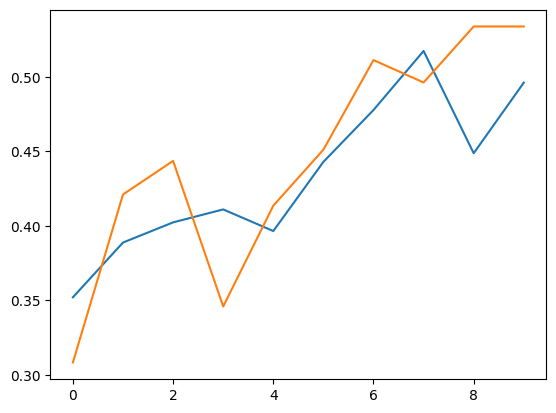

In [11]:
# Show accuracy plot
plt.plot(range(10), history.history['accuracy'])
plt.plot(range(10), history.history['val_accuracy'])
plt.show()

Things appear to be working.

# Make a Better Model
Try to acheive validation accuracy greater than 75%.

In [27]:
# Clear the keras session if needed
tf.keras.backend.clear_session()

In [28]:
model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 32)        0

In [29]:
history2 = model2.fit(
    ds_train_process,
    epochs=100,
    validation_data=ds_validation_process
)

Epoch 1/100
33/33 [==============================] - 6s 61ms/step - loss: 1.1912 - accuracy: 0.3366 - val_loss: 1.0984 - val_accuracy: 0.3383
Epoch 2/100
33/33 [==============================] - 3s 58ms/step - loss: 1.0924 - accuracy: 0.3520 - val_loss: 1.0884 - val_accuracy: 0.3835
Epoch 3/100
33/33 [==============================] - 3s 56ms/step - loss: 1.0274 - accuracy: 0.4952 - val_loss: 1.0305 - val_accuracy: 0.4962
Epoch 4/100
33/33 [==============================] - 3s 56ms/step - loss: 0.9497 - accuracy: 0.5493 - val_loss: 0.9837 - val_accuracy: 0.5714
Epoch 5/100
33/33 [==============================] - 3s 58ms/step - loss: 0.9418 - accuracy: 0.5445 - val_loss: 0.9651 - val_accuracy: 0.5714
Epoch 6/100
33/33 [==============================] - 3s 58ms/step - loss: 0.8997 - accuracy: 0.5696 - val_loss: 0.8652 - val_accuracy: 0.6617
Epoch 7/100
33/33 [==============================] - 3s 60ms/step - loss: 0.8903 - accuracy: 0.5899 - val_loss: 0.8636 - val_accuracy: 0.6617
Epoch 

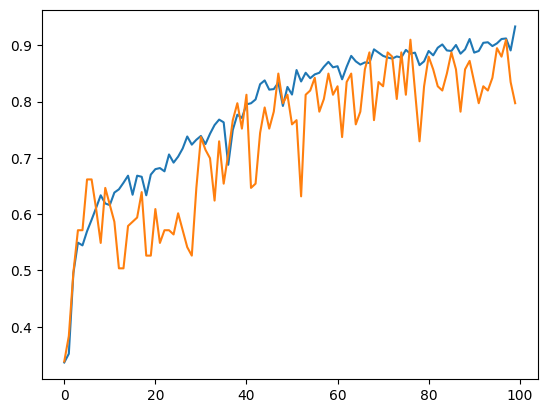

In [30]:
# Show accuracy plot
plt.plot(range(100), history2.history['accuracy'])
plt.plot(range(100), history2.history['val_accuracy'])
plt.show()

Some overfitting is definitely happening. But accuracy and validation accuracy are getting better over epochs.

In [ ]:
model2.save("beanmodel.h5")